In [1]:
!pip install -U gdown
import gdown

file_id = "17dJko5mDYFbCNYRBWLSTKxLp6FihKje5"
url = f"https://drive.google.com/uc?id={file_id}"
output = "splits.zip"

gdown.download(url, output, quiet=False)

!unzip -q splits.zip -d /content/

Downloading...
From (original): https://drive.google.com/uc?id=17dJko5mDYFbCNYRBWLSTKxLp6FihKje5
From (redirected): https://drive.google.com/uc?id=17dJko5mDYFbCNYRBWLSTKxLp6FihKje5&confirm=t&uuid=130daf42-02d1-4fd8-a869-3e190a53b9f9
To: /content/splits.zip
100%|██████████| 1.73G/1.73G [00:25<00:00, 67.2MB/s]


In [85]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import random

### We make sure that our results are reproducible

In [86]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [87]:
IMG_SIZE = 224
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [88]:
def load_pretrained_model(model_path, original_num_classes=10):
    model = timm.create_model(
        'vit_base_patch16_224',
        pretrained=False,  # we have our own weights
        num_classes=original_num_classes,
        depth=12
    )
    model.load_state_dict(torch.load(model_path))
    return model.to(DEVICE)

In [89]:
def create_new_dataloader(data_root):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(data_root, transform=transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    return loader, dataset.classes

### We evaluate the model. We assign the unknown class if the probability of the predicted label is less than the threshold.



In [90]:
def evaluate_with_thresholds(model, test_loader, thresholds):
    fixed_classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'unknown', 'up', 'yes']
    results = []

    for threshold in thresholds:
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Threshold {threshold}'):
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                confs, preds = torch.max(probs, 1)

                preds = preds.cpu().numpy()
                confs = confs.cpu().numpy()
                labels = labels.cpu().numpy()

                for i in range(len(preds)):
                    if confs[i] < threshold:
                        processed_pred = 8  # unknown
                    elif preds[i] < 8:
                        processed_pred = preds[i]
                    elif preds[i] == 8:
                        processed_pred = 9  # up
                    elif preds[i] == 9:
                        processed_pred = 10  # yes
                    else:
                        processed_pred = 8

                    all_preds.append(processed_pred)
                    all_labels.append(labels[i])

        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)

        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'balanced_accuracy': balanced_accuracy,
            'f1_score': f1,
            'predictions': all_preds,
            'labels': all_labels
        })

        print(f"Threshold {threshold:.7f} | Accuracy: {100 * accuracy:.2f}% | F1: {100 * f1:.2f}% | Balanced Accuracy: {100 * balanced_accuracy:.2f}%")

    return results

In [91]:
def analyze_thresholds(results):
    df = pd.DataFrame(results)

    best_acc_idx = df['accuracy'].idxmax()
    best_f1_idx = df['f1_score'].idxmax()
    best_bacc_idx = df['balanced_accuracy'].idxmax()

    print("\nBest Thresholds:")
    print(f"Highest Accuracy: {df.iloc[best_acc_idx]['threshold']:.7f} (Acc: {100 * df.iloc[best_acc_idx]['accuracy']:.2f}%)")
    print(f"Highest F1 Score: {df.iloc[best_f1_idx]['threshold']:.7f} (F1: {100 * df.iloc[best_f1_idx]['f1_score']:.2f}%)")
    print(f"Highest Balanced Accuracy: {df.iloc[best_bacc_idx]['threshold']:.7f} (Balanced Acc: {100 * df.iloc[best_bacc_idx]['balanced_accuracy']:.2f}%)")

    # converting thresholds to strings (for equal spacing)
    threshold_labels = [f"{t:.7f}" for t in df['threshold']]

    plt.figure(figsize=(14, 7))
    plt.plot(threshold_labels, 100 * df['accuracy'], 'o-', label='Accuracy')
    plt.plot(threshold_labels, 100 * df['f1_score'], 'o-', label='F1 Score')
    plt.plot(threshold_labels, 100 * df['balanced_accuracy'], 'o-', label='Balanced Accuracy')

    plt.xlabel('Threshold')
    plt.ylabel('Score [%]')
    plt.title('Model Performance vs Confidence Threshold')
    plt.legend()
    plt.grid(True)

    # for better readability
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("=========")

    # confusion matrix for best F1 threshold
    best_f1_threshold = df.iloc[best_f1_idx]['threshold']
    best_f1_preds = df.iloc[best_f1_idx]['predictions']
    best_f1_labels = df.iloc[best_f1_idx]['labels']

    class_names = ['down', 'go', 'left', 'no', 'off', 'on', 'right',
                   'stop', 'unknown', 'up', 'yes']

    cm = confusion_matrix(best_f1_labels, best_f1_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix (Best F1 Threshold = {best_f1_threshold:.7f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return df.iloc[:, :3]

In [92]:
thresholds = [
    0.5, 0.6, 0.7, 0.8, 0.9,
    0.95, 0.99, 0.995, 0.999,
    0.9995, 0.9999, 0.99995, 0.99999,
    0.999999, 0.9999999
]

In [93]:
model = load_pretrained_model('depth12_lr0.0001_model.pth')

### Now we check what are the best thresholds. First, the unknown class is similar size to the rest of classes. Then, the unknown class is approximately 20x bigger than the rest of the classes.

Threshold 0.5: 100%|██████████| 161/161 [01:08<00:00,  2.35it/s]


Threshold 0.5000000 | Accuracy: 89.73% | F1: 86.58% | Balanced Accuracy: 88.65%


Threshold 0.6: 100%|██████████| 161/161 [01:07<00:00,  2.40it/s]


Threshold 0.6000000 | Accuracy: 90.13% | F1: 87.77% | Balanced Accuracy: 89.15%


Threshold 0.7: 100%|██████████| 161/161 [01:06<00:00,  2.41it/s]


Threshold 0.7000000 | Accuracy: 90.64% | F1: 88.93% | Balanced Accuracy: 89.75%


Threshold 0.8: 100%|██████████| 161/161 [01:07<00:00,  2.40it/s]


Threshold 0.8000000 | Accuracy: 90.97% | F1: 89.66% | Balanced Accuracy: 90.15%


Threshold 0.9: 100%|██████████| 161/161 [01:07<00:00,  2.40it/s]


Threshold 0.9000000 | Accuracy: 91.34% | F1: 90.57% | Balanced Accuracy: 90.63%


Threshold 0.95: 100%|██████████| 161/161 [01:07<00:00,  2.40it/s]


Threshold 0.9500000 | Accuracy: 91.51% | F1: 91.06% | Balanced Accuracy: 90.88%


Threshold 0.99: 100%|██████████| 161/161 [01:07<00:00,  2.39it/s]


Threshold 0.9900000 | Accuracy: 91.92% | F1: 92.01% | Balanced Accuracy: 91.47%


Threshold 0.995: 100%|██████████| 161/161 [01:09<00:00,  2.31it/s]


Threshold 0.9950000 | Accuracy: 91.98% | F1: 92.31% | Balanced Accuracy: 91.62%


Threshold 0.999: 100%|██████████| 161/161 [01:07<00:00,  2.38it/s]


Threshold 0.9990000 | Accuracy: 91.20% | F1: 91.92% | Balanced Accuracy: 90.94%


Threshold 0.9995: 100%|██████████| 161/161 [01:07<00:00,  2.39it/s]


Threshold 0.9995000 | Accuracy: 91.05% | F1: 91.91% | Balanced Accuracy: 90.84%


Threshold 0.9999: 100%|██████████| 161/161 [01:07<00:00,  2.39it/s]


Threshold 0.9999000 | Accuracy: 89.61% | F1: 90.99% | Balanced Accuracy: 89.50%


Threshold 0.99995: 100%|██████████| 161/161 [01:06<00:00,  2.41it/s]


Threshold 0.9999500 | Accuracy: 88.41% | F1: 90.14% | Balanced Accuracy: 88.35%


Threshold 0.99999: 100%|██████████| 161/161 [01:07<00:00,  2.40it/s]


Threshold 0.9999900 | Accuracy: 84.70% | F1: 87.48% | Balanced Accuracy: 84.75%


Threshold 0.999999: 100%|██████████| 161/161 [01:07<00:00,  2.40it/s]


Threshold 0.9999990 | Accuracy: 74.19% | F1: 79.53% | Balanced Accuracy: 74.42%


Threshold 0.9999999: 100%|██████████| 161/161 [01:07<00:00,  2.40it/s]


Threshold 0.9999999 | Accuracy: 59.82% | F1: 67.00% | Balanced Accuracy: 60.25%

Best Thresholds:
Highest Accuracy: 0.9950000 (Acc: 91.98%)
Highest F1 Score: 0.9950000 (F1: 92.31%)
Highest Balanced Accuracy: 0.9950000 (Balanced Acc: 91.62%)


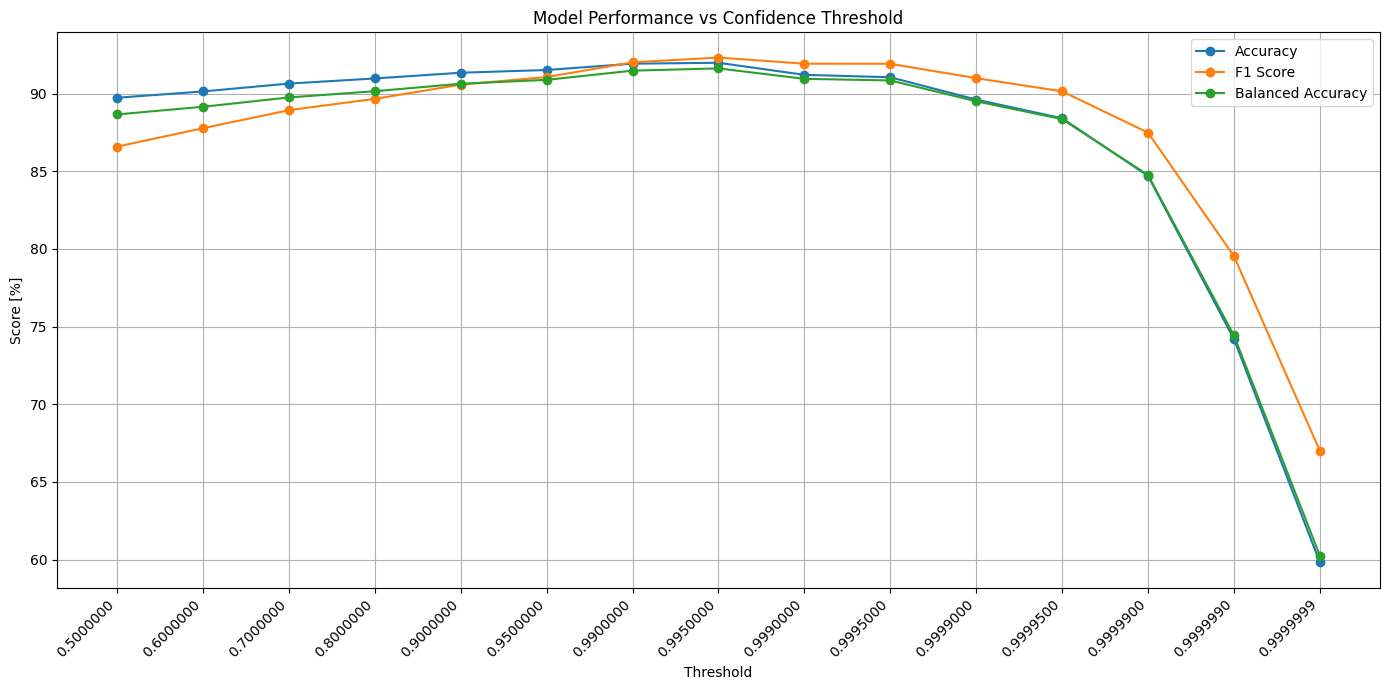

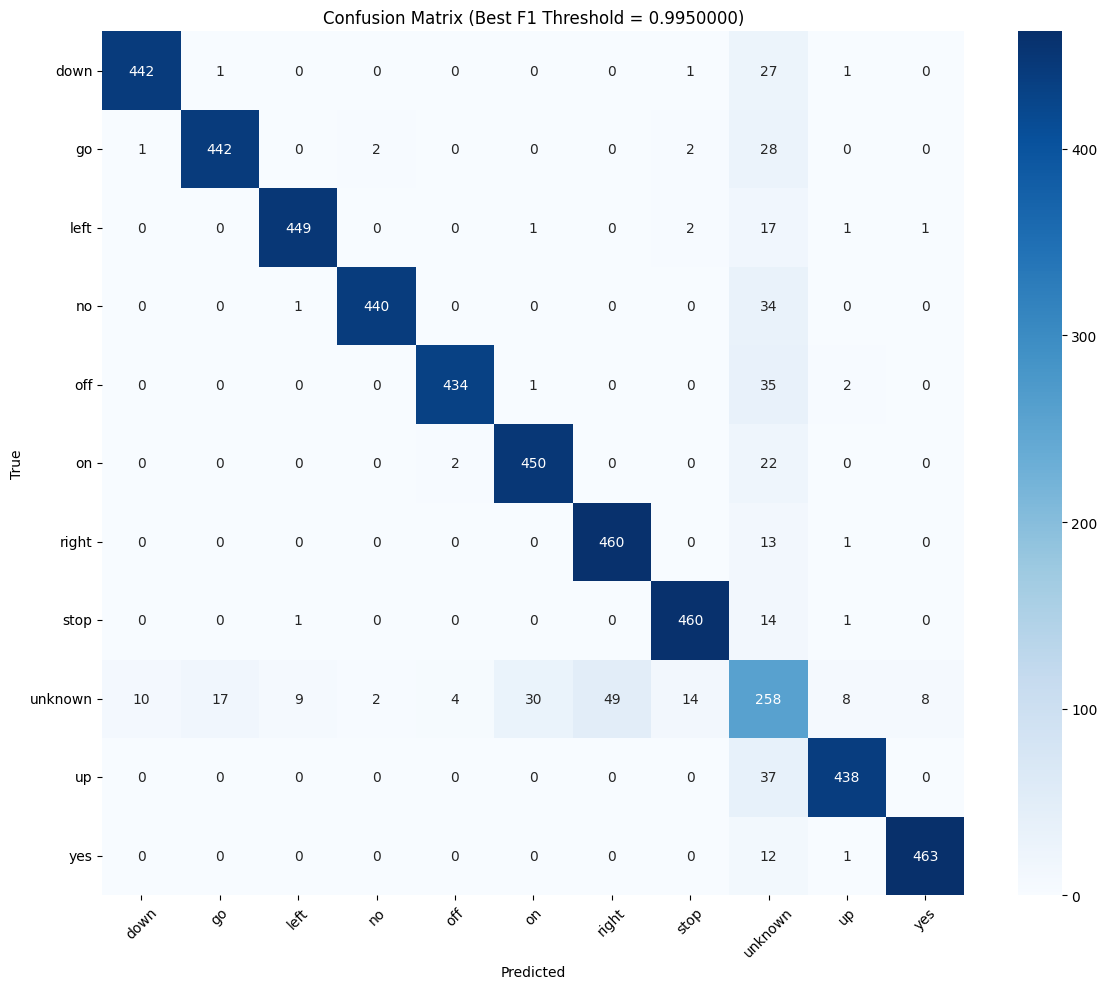

In [94]:
test_loader, _ = create_new_dataloader('splits/split_10_unknown_balanced/test')

results = evaluate_with_thresholds(model, test_loader, thresholds)
df = analyze_thresholds(results)

df.to_csv('threshold_analysis_results.csv', index=False)

Threshold 0.5: 100%|██████████| 405/405 [02:48<00:00,  2.41it/s]


Threshold 0.5000000 | Accuracy: 37.88% | F1: 25.14% | Balanced Accuracy: 88.65%


Threshold 0.6: 100%|██████████| 405/405 [02:49<00:00,  2.39it/s]


Threshold 0.6000000 | Accuracy: 41.84% | F1: 32.74% | Balanced Accuracy: 89.06%


Threshold 0.7: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.7000000 | Accuracy: 45.62% | F1: 39.30% | Balanced Accuracy: 89.47%


Threshold 0.8: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.8000000 | Accuracy: 50.03% | F1: 46.22% | Balanced Accuracy: 89.96%


Threshold 0.9: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9000000 | Accuracy: 56.09% | F1: 54.75% | Balanced Accuracy: 90.49%


Threshold 0.95: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9500000 | Accuracy: 61.01% | F1: 60.97% | Balanced Accuracy: 90.88%


Threshold 0.99: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9900000 | Accuracy: 70.13% | F1: 71.33% | Balanced Accuracy: 91.45%


Threshold 0.995: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9950000 | Accuracy: 73.29% | F1: 74.61% | Balanced Accuracy: 91.43%


Threshold 0.999: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9990000 | Accuracy: 79.55% | F1: 80.79% | Balanced Accuracy: 91.05%


Threshold 0.9995: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9995000 | Accuracy: 81.75% | F1: 82.88% | Balanced Accuracy: 90.91%


Threshold 0.9999: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9999000 | Accuracy: 85.43% | F1: 86.23% | Balanced Accuracy: 89.63%


Threshold 0.99995: 100%|██████████| 405/405 [02:48<00:00,  2.41it/s]


Threshold 0.9999500 | Accuracy: 86.41% | F1: 87.07% | Balanced Accuracy: 88.41%


Threshold 0.99999: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9999900 | Accuracy: 88.21% | F1: 88.47% | Balanced Accuracy: 84.84%


Threshold 0.999999: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9999990 | Accuracy: 87.34% | F1: 86.83% | Balanced Accuracy: 74.55%


Threshold 0.9999999: 100%|██████████| 405/405 [02:48<00:00,  2.40it/s]


Threshold 0.9999999 | Accuracy: 83.12% | F1: 81.19% | Balanced Accuracy: 60.33%

Best Thresholds:
Highest Accuracy: 0.9999900 (Acc: 88.21%)
Highest F1 Score: 0.9999900 (F1: 88.47%)
Highest Balanced Accuracy: 0.9900000 (Balanced Acc: 91.45%)


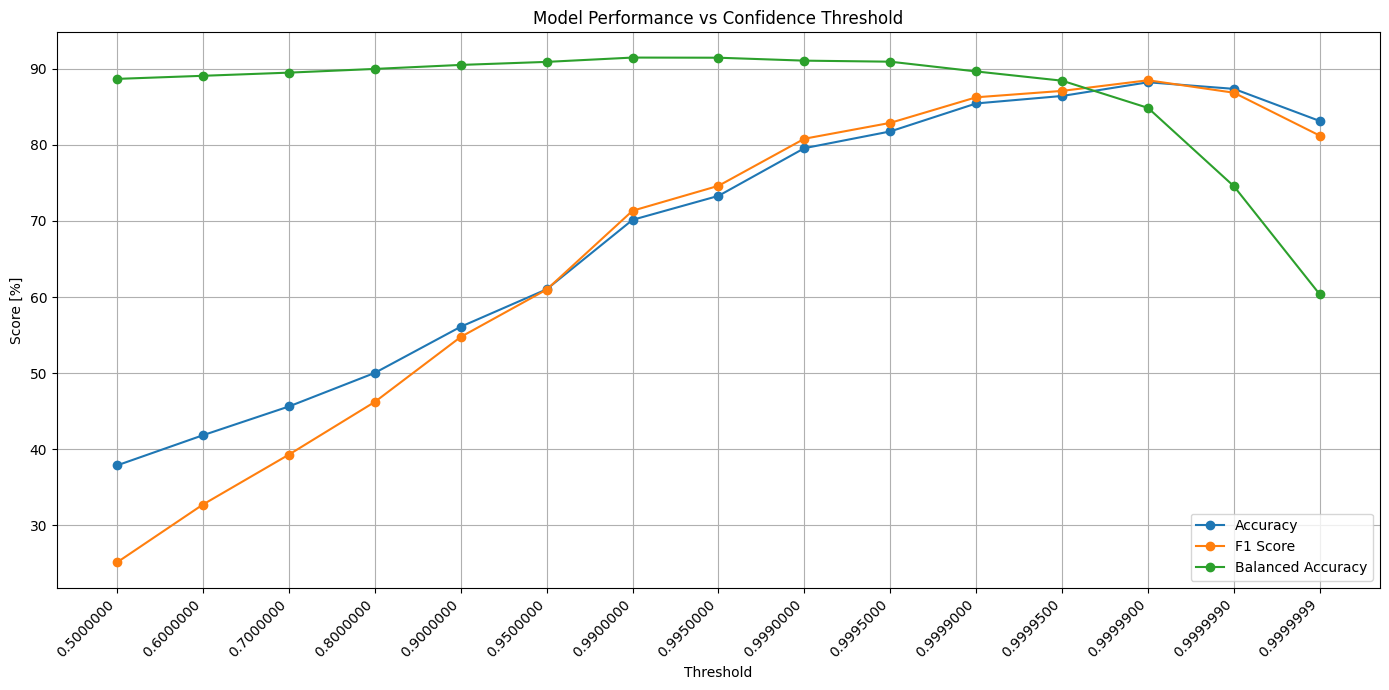

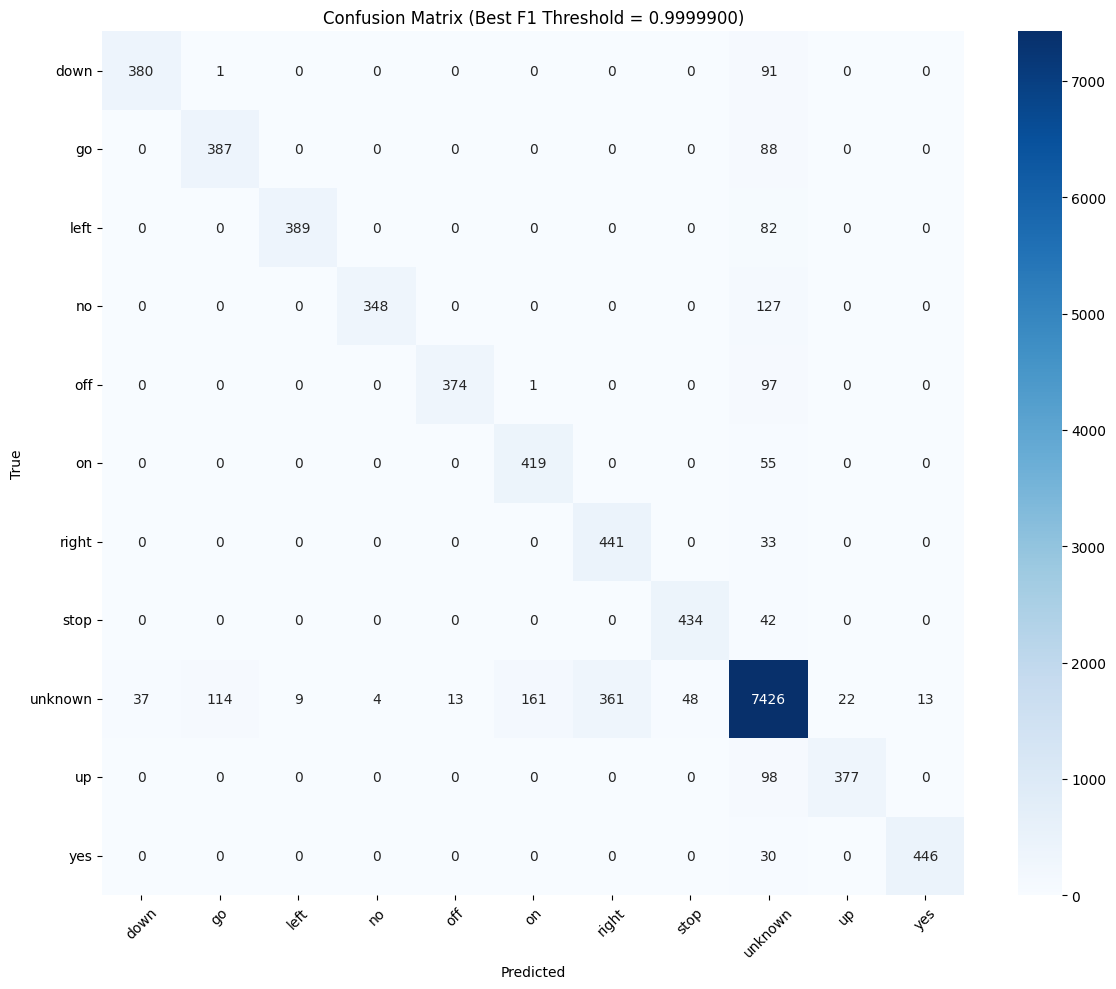

In [95]:
test_loader_all, _ = create_new_dataloader('splits/split_10_unknown/test')

results_all = evaluate_with_thresholds(model, test_loader_all, thresholds)
df_all = analyze_thresholds(results_all)

df_all.to_csv('threshold_analysis_results_all.csv', index=False)